In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn import datasets
from sklearn import svm
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, precision_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
   )

import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import AUC

import warnings

import holoviews as hv

from datetime import datetime

from xgboost import XGBRFClassifier

import os

from sklearn.neural_network import MLPClassifier

import pickle

from sklearn.model_selection import GridSearchCV, train_test_split


In [2]:
df=pd.read_csv('/content/lending-club-loan_ML.csv', low_memory=False)

In [3]:
def save_score(true, pred, model_name, train=True, auc_roc=None):
    timestamp = datetime.now().strftime('%Y%m')
    file_name = f"{model_name}_TestResults_{timestamp}.csv"

    clf_report = classification_report(true, pred, output_dict=True)
    accuracy = accuracy_score(true, pred) * 100
    roc_auc = roc_auc_score(true, pred) * 100
    confusion = confusion_matrix(true, pred)

    if auc_roc is not None:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'AUC-ROC': [roc_auc],
            'Classification Report': [clf_report],
            'Confusion Matrix': [confusion.tolist()]
        })
    else:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'AUC-ROC': [roc_auc],
            'Classification Report': [clf_report],
            'Confusion Matrix': [confusion.tolist()]
        })

    current_dir = os.getcwd()
    pruebas_dir = os.path.join(current_dir, 'Pruebas')
    os.makedirs(pruebas_dir, exist_ok=True)

    # Unir la ruta del directorio 'pruebas' con el nombre del archivo CSV
    file_path = os.path.join(pruebas_dir, file_name)

    result_df.to_csv(file_path, index=False)

In [4]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

        # Guardar resultados en un archivo CSV
        save_score(true, pred, model_name, train=True)

    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

        # Guardar resultados en un archivo CSV
        save_score(true, pred, model_name, train=False)

In [5]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    # Predicciones del modelo
    preds = model.predict(X_test)

    # Matriz de confusión
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()

    # Calcular porcentajes
    total_correct = tp + tn
    total_errors = fp + fn
    percent_correct = total_correct / (tp + tn + fp + fn) * 100
    percent_errors = total_errors / (tp + tn + fp + fn) * 100

    # Configurar el gráfico
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['True Neg', 'True Pos'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Imprimir resultados
    print(f"\nResults for {model_name}:")
    print(f"Total Correct: {total_correct} ({percent_correct:.2f}%)")
    print("--" * 30)
    print(f"True Positives (TP): {tp} ({tp / (tp + fn) * 100:.2f}%)")
    print(f"True Negatives (TN): {tn} ({tn / (tn + fp) * 100:.2f}%)")
    print("\nTotal Errors:")
    print(f"False Positives (FP): {fp} ({fp / (tn + fp) * 100:.2f}%)")
    print(f"False Negatives (FN): {fn} ({fn / (tp + fn) * 100:.2f}%)")

In [6]:
def plot_roc_pr_curves(model, X_test, y_test, model_name):
    # Curva ROC
    y_test_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
    roc_auc = roc_auc_score(y_test, y_test_probs)

    # Curva P-R
    precision, recall, _ = precision_recall_curve(y_test, y_test_probs)

    # Crear la figura con dos subgráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Graficar Curva ROC
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('Tasa de Falsos Positivos')
    ax1.set_ylabel('Tasa de Verdaderos Positivos')
    ax1.set_title(f'Curva ROC - {model_name}')
    ax1.legend(loc='lower right')

    # Graficar Curva P-R
    ax2.plot(recall, precision, color='darkorange', lw=2, label='P-R curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [18]:
# Handle missing values in the target variable
missing_rows_train_y = y_train.isnull()
X_train_copy = X_train[~missing_rows_train_y]
y_train_copy = y_train.dropna()

# Handle missing values in the feature variables
imputer = KNNImputer()
X_train_imputed = imputer.fit_transform(X_train_copy)

# División de datos (if not already done)
X_train_final, X_test, y_train_final, y_test = train_test_split(X_train_imputed, y_train_copy, test_size=0.2, random_state=42)

# Instanciamos el PCA y el pipeline para Regresión Logística
pca = PCA(n_components=0.95)  # Elige el número de componentes que explica al menos el 95% de la varianza
xgboost = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('classifier', XGBRFClassifier(random_state=42))
])

# Parámetros para XGBoost
xgboost_params = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.1, 0.5, 1.0],
    'classifier__max_depth': [2, 3, 4],
    'classifier__subsample': [0.8, 1.0],
}

# Grid search con modelo XGBoost
gs_xgboost = GridSearchCV(xgboost, xgboost_params, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

# Entrenamos el grid search
gs_xgboost.fit(X_train_final, y_train_final)

# Resultados del grid search para XGBoost
print(f'Precisión en el conjunto de entrenamiento: {gs_xgboost.best_score_:.4f}')
print(f'Mejores parámetros: {gs_xgboost.best_params_}')
print('Mejor estimador:')
print(gs_xgboost.best_estimator_)

# Precisión y recall en el conjunto de prueba
preds_xgboost = gs_xgboost.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, preds_xgboost)
recall = recall_score(y_test, preds_xgboost)

print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')
print(f'Recall en el conjunto de prueba: {recall:.4f}')

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Precisión en el conjunto de entrenamiento: 0.8773
Mejores parámetros: {'classifier__learning_rate': 1.0, 'classifier__max_depth': 4, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Mejor estimador:
Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('classifier',
                 XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bytree=None,
                                 device=None, early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None, max_bin=None,
                                 max_cat_thre

Training set scores:
Accuracy: 0.8813
Precision: 0.8730
Recall: 0.9990
F1 Score: 0.9317
Test set scores:
Accuracy: 0.8657
Precision: 0.8571
Recall: 0.9986
F1 Score: 0.9225


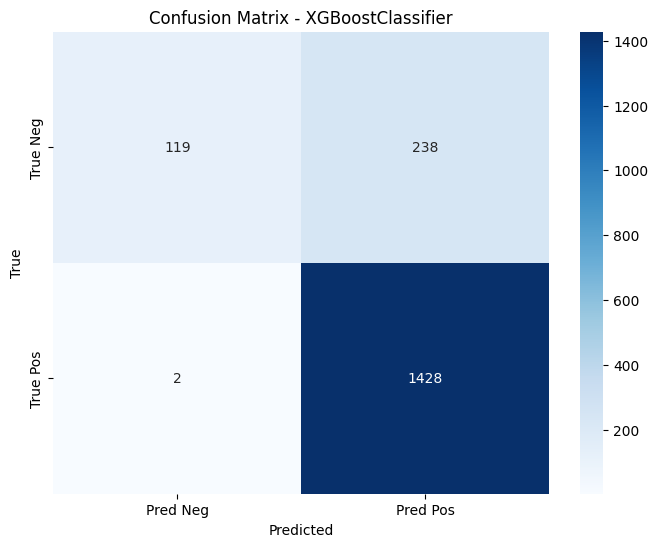


Results for XGBoostClassifier:
Total Correct: 1547 (86.57%)
------------------------------------------------------------
True Positives (TP): 1428 (99.86%)
True Negatives (TN): 119 (33.33%)

Total Errors:
False Positives (FP): 238 (66.67%)
False Negatives (FN): 2 (0.14%)


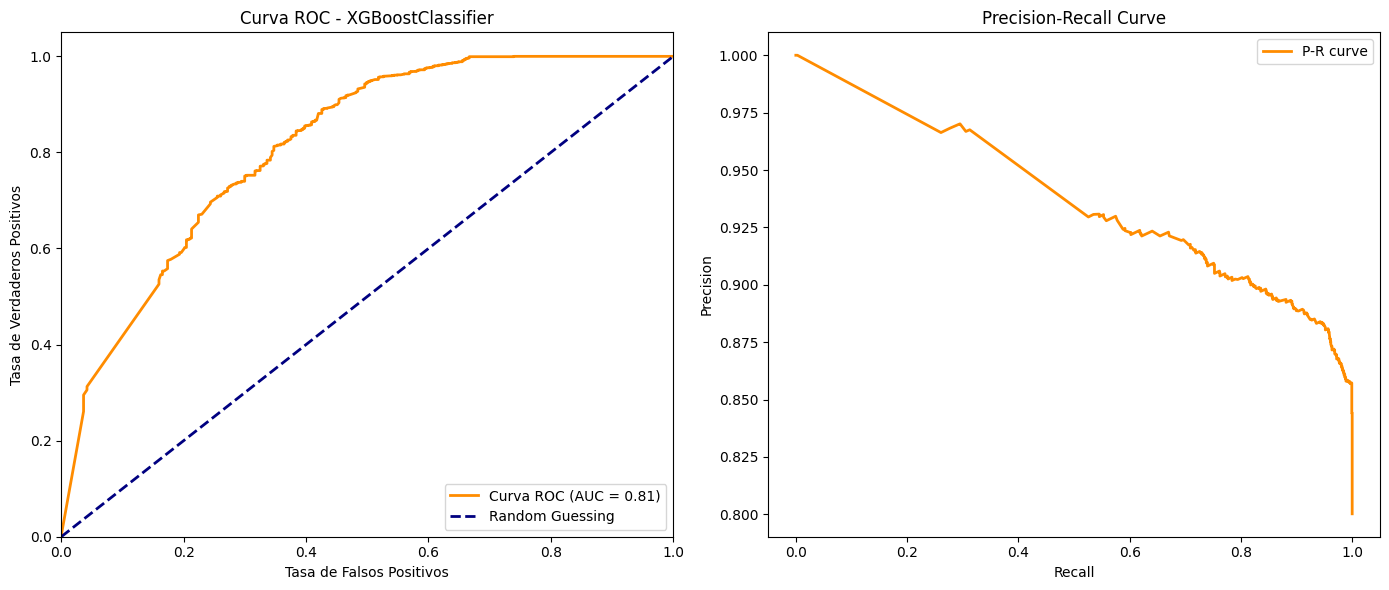

In [19]:
# Obtener las predicciones del modelo
threshold = 0.5  # Umbral para convertir probabilidades en clases
train_preds_xgboost = (gs_xgboost.best_estimator_.predict_proba(X_train_final)[:, 1] > threshold).astype(int)
test_preds_xgboost = (gs_xgboost.best_estimator_.predict_proba(X_test)[:, 1] > threshold).astype(int)

model_name = 'XGBoostClassifier'
# Llamada a las funciones después de entrenar el modelo
print_score(y_train_final, train_preds_xgboost, train=True)
print_score(y_test, test_preds_xgboost, train=False)
plot_confusion_matrix(gs_xgboost.best_estimator_, X_test, y_test, model_name)
plot_roc_pr_curves(gs_xgboost.best_estimator_, X_test, y_test, model_name)
save_score(y_train_final, train_preds_xgboost, model_name, train=True)
save_score(y_test, test_preds_xgboost, model_name, train=False)

In [ ]:
# Guardar el modelo
import pickle

with open('finished_model.model_XGBoost', "wb") as archivo_salida:
    pickle.dump(models_gridsearch['XG Boost'].best_estimator_, archivo_salida)